## 可以画出每次serving data 和training data DDLA的分布

In [264]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn import tree
import pydotplus
from subprocess import check_call
from graphviz_sql.extract import to_sql 
import sqlite3
import pickle
from scipy import stats
import sys
import argparse
import pickle
from scipy import stats
import sys
import argparse
import os
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import time

In [265]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [266]:
def find_distributions(model, data):
    X_test = data[['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
       'occupation', 'relationship', 'capital_gain', 'capital_loss',
       'hours_week', 'country', 'race', 'sex','marital']]
    y_test = data[["income"]]
    y_predict = model.predict(X_test)
    y_test_DT = y_test.reset_index()
    y_predict_DT = pd.DataFrame(y_predict, columns = ['predict'])
    data_M2 = pd.concat([y_test_DT, y_predict_DT], axis=1, join='inner')
    data_M2['result'] = np.where(data_M2["income"]==data_M2['predict'],'0','1')
    data_M2.set_index(["index"], inplace=True)
    data_M2 = pd.concat([data_M2, X_test], axis=1, join='inner')
    
    x_DT = data_M2[['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'occupation', 'relationship', 'capital_gain', 'capital_loss',
       'hours_week', 'country', 'race', 'sex', 'marital']]
    y_DT = data_M2[["result"]]
    X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(x_DT, y_DT, test_size=0.5, random_state=42)
    
    # ### SMOTE
    # y_train_DT = y_train_DT.astype('int')
    # oversample = SMOTE(random_state=42, k_neighbors=2)
    # X_balance_DT,Y_balance_DT = oversample.fit_resample(X_train_DT,y_train_DT)
    # X_balance_DT = pd.DataFrame(X_balance_DT, columns = X_train_DT.columns)
    
    #train Decision tree
    model_DT = DecisionTreeClassifier(max_depth=8,
                             
                                      random_state=42
                               )
    model_DT.fit(X_train_DT, y_train_DT)
    y_test_DT = y_test_DT.astype('int')
    y_predict_DT = model_DT.predict(X_test_DT)
    
    ##save DT tree plan dot
    dot_data=tree.export_graphviz(model_DT, out_file='/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot', feature_names= x_DT.columns,
                               class_names=['0', '1'], node_ids=True,
                              filled=True, rounded=True,  
                              special_characters=True)
    check_call(['dot','-Tpng','/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot','-o','/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_CatBoost_3.png'])
    ##save sql doc
    to_sql('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot', '/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql')
    
    X_test['predict'] = y_predict
    X_test['result'] = np.where(y_test['income']==X_test['predict'],'0','1')
    data_result = X_test
    data_result['team'] = 0
    df = data_result
    #connect to a database
    conn = sqlite3.connect("pipleine_ourM3.db") #if the db does not exist, this creates a Any_Database_Name.db file in the current directory
    #store your table in the database:
    df.to_sql('Some_Table_Name', conn)
    #read a SQL Query out of your database and into a pandas dataframe
    sql_string = 'SELECT * FROM Some_Table_Name'
    df = pd.read_sql(sql_string, conn)
    # Open and read the file as a single buffer
    fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'r')
    sqlFile = fd.read()
    fd.close()
    ## prepare sql document
    sqlFile=sqlFile.replace('select case', 'UPDATE Some_Table_Name \nSET team = \nCASE')
    n=sqlFile.count('then 0 ')

    sqlFile = sqlFile.replace('then 0 ', 'then -xxx')
    for i in range(n):
        sqlFile = sqlFile.replace('-xxx', str(-i), 1)

    m=sqlFile.count('then 1 ')
    sqlFile = sqlFile.replace('then 1 ', 'then +xxx')
    for i in range(m):
        sqlFile = sqlFile.replace('+xxx', str(i+1), 1)
    fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'w+')
    fd.write(sqlFile)
    fd.close()

    ## compile sql doc
    sql_string = sqlFile.split(';')
    cur = conn.cursor()
    for command in sql_string:
        cur.execute(command)
    os.remove("pipleine_ourM3.db")
    ##read data from database
    sql_string='SELECT * FROM Some_Table_Name;'
    df = pd.read_sql(sql_string, conn)
    df1= df.team.value_counts()
    df1.to_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_team_count_pepiline.csv")    
    g = df.groupby("team")
    m=g['result'].value_counts(normalize=True,sort=False)
    acc=m.loc[-400:400,'0']
    acc=acc.to_frame()
    acc.to_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_acc_result_pipeline.csv")    
    df1=pd.read_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_team_count_pepiline.csv")
    df1.set_index(["Unnamed: 0"], inplace=True)
    df1 = df1.rename_axis('Team_number')
    df1 = df1.rename(columns={'team': 'account'})
    acc = pd.read_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_acc_result_pipeline.csv")
    acc=acc[['team','result.1']]
    acc.set_index(["team"], inplace=True)
    acc = acc.rename_axis('Team_number')
    acc = acc.rename(columns={'result.1': 'Accuracy'})
    List_accuracy = pd.concat([acc, df1], axis=1, join='inner')
    accuracy_team=List_accuracy.reset_index()
    
    #low_accuracy_teams=low_accuracy_teams.reset_index() 
    accuracy_team['percentage']= accuracy_team['account']/X_test['age'].count()
    low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < 0.93959]
#     X = low_accuracy_teams['Team_number']
#     y = low_accuracy_teams['percentage']

#     # 创建柱状图
#     plt.bar(X, y)

#     # 设置 X 轴和 Y 轴标签
            

#     # 显示图形
#     plt.show()

    return accuracy_team
    


In [267]:
# 定义检测函数
from scipy.stats import ks_2samp
def drift_detection(X_train, X_test, threshold=0.1):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
        
    is_drift = any([result["drift"] for result in results])
        
    # 返回结果列表
    return is_drift

In [268]:
import numpy as np
from sklearn import metrics

def mmd_fast(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
        # 根据MMD值判断是否存在数据漂移
    print(f'mmd : {mmd}')
    is_drift_mmd=False
    if mmd > 0.00001:
        is_drift_mmd=True
    return is_drift_mmd

In [269]:
####  H-D
join=os.path.join
from sklearn.decomposition import PCA
# parser = argparse.ArgumentParser()

# parser.add_argument('--n', type=int, default=300)
# parser.add_argument('--seed', type=int, default=1)
# parser.add_argument('--log_dir', type=str, default='logs')
# parser.add_argument('--runs', type=int, default=1)

n=300
seed=1
log_dir='logs'
runs=1
bandwidth = 'scott'
max_data_size = n
# args = parser.parse_args()
#scott

np.random.seed(seed)

def get_kde_estimates(bandwidth, data) :
	# kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
	data = data.T
	kernel = stats.gaussian_kde(data, bandwidth)
	return kernel.evaluate(data)




if not os.path.exists(log_dir):
	os.makedirs(log_dir)




# dataX=df_budapest.drop(columns=["BBQ_weather","DATE","MONTH"])
# dataY=df_oslo.drop(columns=["BBQ_weather","DATE","MONTH"])
# dataX = dataX.reset_index(drop=True)
# dataY = dataY.reset_index(drop=True)
# dataX = dataX.to_numpy()
# dataY = dataY.to_numpy()




fname = join(log_dir, 'result_' + str(max_data_size) + '.txt')

def in_top_k(scores, k):
    indices = np.argsort(scores)[::-1]
    pos = np.where(indices==0)[0][0]
    return pos <= k

def evaluate(data_1,data_2):
    scores = []
    data1 = data_1.sample(n=300, replace=False, random_state=42).to_numpy()
    data2 = data_2.to_numpy()
  
    for rep in range(100):

        if rep != 0:
            data_all = np.concatenate([data1, data2], axis=0)
            data_all = data_all[np.random.permutation(range(data_all.shape[0]))]
            data1 = data_all[:max_data_size]
            data2 = data_all[max_data_size:]
        datam = np.concatenate([data1[:max_data_size//2], data2[:max_data_size//2]], axis=0)
        pca = PCA(n_components=5)

        # 将13维数组X降维到5维
        data1 = pca.fit_transform(data1)
        data2 = pca.fit_transform(data2)
        datam = pca.fit_transform(datam)
        logprob_1 = get_kde_estimates(bandwidth, data1)
        logprob_2 = get_kde_estimates(bandwidth, data2)
        logprob_m = get_kde_estimates(bandwidth, datam)

        vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
        with open(fname, 'a') as f:
            f.write("Scores " + str(np.mean(logprob_1)) + " " + str(np.mean(logprob_2)) + " " + str(np.mean(logprob_m)) + "\n")
        scores.append(vdiv)

    return in_top_k(scores, k=100)



In [270]:
# 读取数据集到dataframe
df_all = pd.read_csv("/Users/sdong/phd_doc/dataset/adult.csv")
#df_all = df_all[["type","amount","oldbalanceOrg","newbalanceOrig","isFraud"]]
#df_oslo = pd.read_csv('/Users/sdong/phd_doc/att/weather_data/oslo_data.csv')
df_all = df_all.rename(columns={
    'age': 'age',
    'workclass': 'workclass',
    'fnlwgt': 'fnlwgt',
    'education': 'education',
    'education.num': 'education_num',
    'marital.status': 'marital',
    'occupation': 'occupation',
    'relationship': 'relationship',
    'capital.gain': 'capital_gain',
    'capital.loss': 'capital_loss',
    'hours.per.week': 'hours_week',
    'native.country': 'country',
    'income': 'income',
    'race': 'race',
    'sex': 'sex'
})
df_all[df_all == '?'] = np.nan
for col in ['workclass', 'occupation', 'country']:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)
df_all.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [271]:
df_all.marital.value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital, dtype: int64

In [272]:
df_all.education.value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [273]:

# 将 income 列的值替换为布尔值
income_bool = df_all['income'].replace({'<=50K': False, '>50K': True})

# 将 income_bool 列添加回原始 DataFrame 中
df_all['income'] = income_bool

# 打印替换后的结果
#print(df[['adult.income', 'income_bool']].head())

In [274]:
df_all.to_csv("/Users/sdong/phd_doc/dataset/adult_prepare.csv", index=False)

In [275]:
df_all.head()
# df_all.race.value_counts()
# df_all.sex.value_counts()


,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,False
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,False
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,False
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,False
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,False


In [276]:
from sklearn import preprocessing

categorical = ['workclass', 'education', 'occupation', 'relationship', 'country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        df_all[feature] = le.fit_transform(df_all[feature])
        
#print(df_all)        
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 假设标签列为 'label'
income = df_all[['income','race', 'sex','marital']]
data = df_all.drop(columns=['income','race', 'sex','marital'], axis=1)

df_all = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

# 将标签列合并回去
df_all_std = pd.concat([df_all, income], axis=1)
df_all_std['race']=df_all_std['race'].replace({'White': 1, 'Black': 2, 'Asian-Pac-Islander': 3, 'Amer-Indian-Eskimo': 4, 'Other': 5})
df_all_std['sex']=df_all_std['sex'].replace({'Male': 6, 'Female': 7})
df_all_std['marital']=df_all_std['marital'].replace({'Married-civ-spouse': 8, 'Never-married': 9, 'Divorced': 10, 'Separated': 11, 'Widowed': 12, 'Married-spouse-absent': 13,'Married-AF-spouse': 14})
# X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
df_all_std.head()

,age,workclass,fnlwgt,education,education_num,occupation,relationship,capital_gain,capital_loss,hours_week,country,income,race,sex,marital
0,3.769612,-0.085296,-1.067997,0.181332,-0.420060,0.720237,-0.277805,-0.14592,10.593507,-0.035429,0.26137,False,1,7,12
1,3.183112,-0.085296,-0.539169,0.181332,-0.420060,-0.790092,-0.277805,-0.14592,10.593507,-1.817204,0.26137,False,1,7,12
2,2.010110,-0.085296,-0.035220,1.214869,-0.031360,0.720237,1.589322,-0.14592,10.593507,-0.035429,0.26137,False,2,7,12
3,1.130359,-0.085296,-0.468215,-1.368974,-2.363558,-0.034928,1.589322,-0.14592,9.461864,-0.035429,0.26137,False,1,7,10
4,0.177296,-0.085296,0.709482,1.214869,-0.031360,0.720237,0.966947,-0.14592,9.461864,-0.035429,0.26137,False,1,7,11


In [277]:




# # 根据列A和列B的值对数据进行排序
# sorted_data = df_all_std.sort_values(by=['occupation', 'relationship'])

# # 计算前5%的样本数量
# train_size = int(0.04 * len(sorted_data))

# # 分割数据为训练数据和测试数据
# train_set = sorted_data[:train_size]
# test_set = sorted_data[train_size:]

# # # 打印训练集和测试集的行数
# print('Train set rows:', len(train_set))
# print('Test set rows:', len(test_set))

In [278]:
import pandas as pd
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
# 按 race 和 sex 列分组
groups = df_all_std.groupby(['race', 'sex'])
groups_size = df_all_std.groupby(['race', 'sex']).size()
print(groups_size)
groups_size

race  sex
1     6      19174
      7       8642
2     6       1569
      7       1555
3     6        693
      7        346
4     6        192
      7        119
5     6        162
      7        109
dtype: int64


race  sex
1     6      19174
      7       8642
2     6       1569
      7       1555
3     6        693
      7        346
4     6        192
      7        119
5     6        162
      7        109
dtype: int64

In [279]:

# 获取白人女性分组的子集作为训练集
train_set = groups.get_group((2, 7))



# 获取其他分组的子集，按顺序合并到测试集中
test_set = pd.concat([groups.get_group(group) for group in groups.groups.keys() if group != (2, 7)])



# 打印训练集和测试集的行数
print('Train set rows:', len(train_set))
print('Test set rows:', len(test_set))
#test_set

Train set rows: 1555
Test set rows: 31006


In [280]:
print(train_set.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'occupation', 'relationship', 'capital_gain', 'capital_loss',
       'hours_week', 'country', 'income', 'race', 'sex', 'marital'],
      dtype='object')


In [281]:
# 查看 adult.income 列的值计数
income_counts = train_set['income'].value_counts()

# 打印值计数
print(income_counts)

False    1465
True       90
Name: income, dtype: int64


In [282]:
x = train_set.drop(columns=["income"])
y = train_set[["income"]]

# splitting the data
X_train_ML, X_test_ML, y_train_ML, y_test_ML = train_test_split(x, y, test_size=0.5, random_state=42)

from imblearn.over_sampling import SMOTE
y_train_ML = y_train_ML.astype('int')
oversample = SMOTE(random_state=42)
X_balance_ML,Y_balance_ML = oversample.fit_resample(X_train_ML,y_train_ML)
X_balance_ML = pd.DataFrame(X_balance_ML, columns = X_train_ML.columns)

CatBoost Accuracy Score is 0.87275
     0   1
0  642  83
1   16  37
[[0.88551724 0.11448276]
 [0.30188679 0.69811321]]


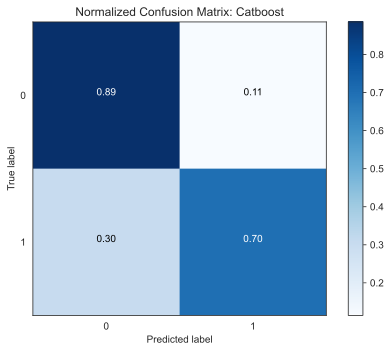

In [283]:
###### LogisticRegression
from xgboost import XGBClassifier
# model = LogisticRegression(C=1,
#                        random_state=42,
#                        solver='lbfgs')

###### LightGBM
# model = LGBMClassifier(num_leaves=31,
#                        max_depth=8, 
#                        learning_rate=0.02,
#                        n_estimators=250,
#                        subsample = 0.8,
#                        colsample_bytree =0.8
#                       )

# model = CatBoostClassifier(iterations=150,
#                            learning_rate=0.2,
#                            od_type='Iter',
#                            verbose=25,
#                            depth=16,
#                            random_seed=42)

# model = RandomForestClassifier(n_estimators=250,
#                               max_depth=12,
#                               min_samples_leaf=16
#                               )

# #######
# model = XGBClassifier(max_depth=10,
#                       n_estimators=150,
#                       min_child_weight=8, 
#                       subsample=0.8, 
#                       learning_rate =0.02,    
#                       seed=42)

model = svm.SVC( C=0.5,random_state=42)

model.fit(X_balance_ML, Y_balance_ML)
y_predict = model.predict(X_test_ML)
# y_predict = (y_predict > 0.5).astype(int)
acc_tre=accuracy_score(y_test_ML, y_predict)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test_ML, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test_ML,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test_ML,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: Catboost')



In [284]:
import joblib
import pickle
    
filename = "/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib"
joblib.dump(model, filename)

['/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib']

In [318]:
data_test = pd.concat([X_test_ML, y_test_ML], axis=1, join='inner')
#data_test.info()
accuracy_team = find_distributions(model, data_test)
print(accuracy_team)

import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

...
=====wrirte sql success======
    Team_number  Accuracy  account  percentage
0           -11  1.000000        1    0.001285
1           -10  1.000000        2    0.002571
2            -9  1.000000        5    0.006427
3            -8  1.000000        6    0.007712
4            -7  0.960000       25    0.032134
5            -6  0.923077       13    0.016710
6            -5  0.857143        7    0.008997
7            -4  1.000000        2    0.002571
8            -3  0.962963       27    0.034704
9            -2  0.928571       14    0.017995
10           -1  1.000000       42    0.053985
11            0  0.994746      571    0.733933
12            1  0.500000        4    0.005141
13            2  0.625000        8    0.010283
14            4  0.500000        2    0.002571
15            5  0.500000        2    0.002571
16            6  0.500000        2    0.002571
17            7  0.500000        4    0.005141
18           12  0.344828       29    0.037275


In [319]:
x_budapest = test_set.drop(columns=["income"])
y_budapest = test_set['income']

# 定义feature和target
target = 'income'
features = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
       'occupation', 'relationship', 'capital_gain', 'capital_loss',
       'hours_week', 'country', 'race', 'sex', 'marital']
y_predict_budapest = model.predict(x_budapest)
#print(y_predict_budapest)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_budapest, y_predict_budapest)))
print(pd.DataFrame(confusion_matrix(y_budapest,y_predict_budapest)))

groups = test_set.groupby(['race', 'sex'])
test_sets = dict(list(groups))
for key in test_sets:
    X_test = test_sets[key][features]
    y_test = test_sets[key][target]
    print(len(X_test))
    y_predict = model.predict(X_test)
    y_predict = (y_predict > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_predict)
    print(f"{key}: {accuracy:.4f}")


CatBoost Accuracy Score is 0.75424
       0     1
0  16781  6474
1   1146  6605
19174
(1, 6): 0.7100
8642
(1, 7): 0.8478
1569
(2, 6): 0.7661
693
(3, 6): 0.7128
346
(3, 7): 0.7832
192
(4, 6): 0.7292
119
(4, 7): 0.9160
162
(5, 6): 0.7963
109
(5, 7): 0.9266


In [320]:
# y_budapest = y_budapest.reset_index()
# y_predict_budapest = pd.DataFrame(y_predict_budapest, columns = ['predict'])

# data_budapest = pd.concat([y_budapest, y_predict_budapest], axis=1, join='inner')
# data_budapest['result'] = np.where(data_budapest['isFraud']==data_budapest['predict'],'0','1')
# data_budapest.set_index(["index"], inplace=True)
# data_budapest = pd.concat([data_budapest, x_budapest], axis=1, join='inner')
# data_budapest_0 = data_budapest[data_budapest['result'] == "0"]
# data_budapest_0 = data_budapest_0.sample(frac=0.05, random_state=42)
# data_budapest_1 = data_budapest[data_budapest['result'] == "1"]
# data_budapest = pd.concat([data_budapest_0, data_budapest_1], axis=0)
# data_budapest = data_budapest.sample(frac=1, random_state=42)
# x_budapest = data_budapest.drop(columns=["isFraud","predict","result"])
# y_budapest = data_budapest.drop(columns=["type", "amount", "oldbalanceOrg", "newbalanceOrig","predict","result"])

# y_predict_budapest = model.predict(x_budapest)
# print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_budapest, y_predict_budapest)))
# print(pd.DataFrame(confusion_matrix(y_budapest,y_predict_budapest)))

# df_budapest=data_budapest[["isFraud","type", "amount", "oldbalanceOrg", "newbalanceOrig"]]

In [321]:
print(len(test_set))

31006


## OUR DDLA

In [322]:
import pandas as pd
import sqlite3
import os

drift_samples_df_1= test_set

drift_samples_df= train_set

new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')
PDDLA_Increase_count = 0
bad_drift_count=0
detect_right=0
AL_labeled_number=0
final_accuracy_list = []
accuracy_sample_list = []
accuracy_sample_list_2 = []
is_drift_KS_list = []
bad_drift_list = []
PDDLA_Increase_list = []
is_drift_mmd_list = []
is_drift_hd_list=[]
Number_AL=[]
trainingtime_list=[]
#os.remove("pipleine_ourM3.db")
#low_acc_teams=0

# 对每个样本添加新的列

batch_size = 300
num_batches = 100
thre_acc = acc_tre
import random
# 设置随机种子
random.seed(123)
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # sample = drift_samples_df_1[start_index:end_index]
    sample = drift_samples_df_1.sample(n=batch_size,  replace=True, random_state=42
                                      )
        #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(sample.index)
    # 读取样本数据
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #sample = drift_samples_df_1.sample(n=500, replace=False, random_state=42+i)
    #print(sample)
    # 添加新的列
    
#     ## k-s test result
#     is_drift_KS = drift_detection(new_train_data.drop(columns=["income"]), sample.drop(columns=["income"]))
#     is_drift_KS_list.append(is_drift_KS)
    
#     ## MMD test result
#     sigma = 1
#     is_drift_mmd = mmd_fast(new_train_data.drop(columns=["income"]), sample.drop(columns=["income"]), sigma=sigma)
#     is_drift_mmd_list.append(is_drift_mmd)
    
#     # H-D test result
#     # 检测数据分布是否漂移
#     is_drift_hd = evaluate(new_train_data.drop(columns=["income"]), sample.drop(columns=["income"]))
#     is_drift_hd_list.append(is_drift_hd)
    
    y_predict_sample = model.predict(sample.drop(columns=["income"]))
    #y_predict_sample = (y_predict_sample > 0.5).astype(int)
    y_sample = sample[["income"]]
    accuracy_sample = accuracy_score(y_sample, y_predict_sample)
    sample["team"] =  0
    df = sample 
    Number_AL.append(0)

                
    #connect to a database
    conn = sqlite3.connect("sample_pipeline5.db") #if the db does not exist, this creates a Any_Database_Name.db file in the current directory
    #store your table in the database:
    df.to_sql('Some_Table_Name', conn)   
    # Open and read the file as a single buffer
    fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'r')
    sqlFile = fd.read()
    fd.close()
    from sqlite3 import OperationalError
    sql_string = sqlFile.split(';')
    cur = conn.cursor()
    for command in sql_string:
        cur.execute(command)
    sql_string='SELECT * FROM Some_Table_Name;'
    df = pd.read_sql(sql_string, conn)
    # 关闭数据库连接
    conn.close()
    # 删除数据库文件
    os.remove("sample_pipeline5.db")
    # 将low_accuracy_team数据框按Team_number升序排列
    #low_acc_teams = low_accuracy_teams.sort_values('Team_number')
    #low_acc_teams.reset_index()
    #print(low_acc_teams)
    # 计算包含在low_accuracy_team中的团队的准确率和百分比的乘积
    team_contributions = []
    for index, row in accuracy_team.iterrows():
        team_num = row['Team_number']
        accuracy = row['Accuracy']
        team_df = df.loc[df['team'] == team_num]
        team_percentage = len(team_df) / len(df)
        
        team_contribution = accuracy * team_percentage
        team_contributions.append(team_contribution)

    # # 计算不包含在low_accuracy_team中的团队的准确率和百分比的乘积
    # other_df = df.loc[~df['team'].isin(low_accuracy_teams['Team_number'].tolist())]
    # other_percentage = len(other_df) / len(df)
    # other_contribution = 0.94 * other_percentage

    # 将两部分相加以获得最终的准确率
    final_accuracy = sum(team_contributions)
    #print(f"The {i} our Accuracy: {final_accuracy}, real acc: {accuracy_sample}")
    print(f"The {i} batch serving data real acc: {accuracy_sample}")
    print(f'accuracy of the model: {thre_acc}')
    low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < thre_acc]
    
    low_accuracy_teams_2 = low_accuracy_teams.copy()  # 复制数据框以避免更改原始数据框
    low_accuracy_teams_2['percentage'] = 0

    for index, row in low_accuracy_teams.iterrows():
        team_num = row['Team_number']
        team_df = df.loc[df['team'] == team_num]
        team_percentage = len(team_df) / len(df)

        low_accuracy_teams_2.at[index, 'percentage'] = team_percentage  # 修改 low_accuracy_teams_2 中相应团队的百分比值



    # print(f"low_accuracy_teams")
    # print(low_accuracy_teams) 
    # print(f"low_accuracy_teams_2")
    # print(low_accuracy_teams_2)
    # print(f"low_accuracy_teams_value1")
    # print(low_accuracy_teams.iloc[0]['Team_number'])
    
    
    
    
    #######################################################
    # drow pecentage data drift in training and serving data
    # 设置柱状图参数
    
#     print(f"the {i} batch serving data's drift figure")
#     bar_width = 0.35
#     opacity = 0.8

#     # 绘制两个数据集的柱状图
#     plt.bar(low_accuracy_teams['Team_number'], low_accuracy_teams['percentage'], bar_width, alpha=opacity, color='b', label='Training data')
#     plt.bar(low_accuracy_teams_2['Team_number'] + bar_width, low_accuracy_teams_2['percentage'], bar_width, alpha=opacity, color='g', label='Serving data')

#     # 设置X轴和Y轴标签
#     plt.xlabel('DDLA ID')
#     plt.ylabel('Percentage of DDLA')

#     # 设置图例
#     plt.legend()

#     # 显示图形
#     plt.show()
    ##################################
    team_numbers = []
    team_numbers_2 = []
    
    
 

    for n in range(len(low_accuracy_teams)):
        if low_accuracy_teams.iloc[n]['Team_number'] == low_accuracy_teams_2.iloc[n]['Team_number']:
            percentage_change = low_accuracy_teams_2.iloc[n]['percentage'] - low_accuracy_teams.iloc[n]['percentage']
            if percentage_change > 0 and percentage_change >= low_accuracy_teams.iloc[n]['percentage'] * 0.1 and low_accuracy_teams_2.iloc[n]['percentage']> 0.01 :
            #and low_accuracy_teams_2.iloc[n]['percentage']> 0.01: 
            #:
                #
                team_numbers.append(low_accuracy_teams.iloc[n]['Team_number'])

    #print(team_numbers)
    
    team_numbers_2 = low_accuracy_teams['Team_number']
    #print(team_numbers_2)
    ##################
    
    final_accuracy_list.append(final_accuracy)
    accuracy_sample_list.append(accuracy_sample)
    accuracy_sample_list_2.append(accuracy_sample)
    trainingtime_list.append(0)
    if len(team_numbers):
        print(f"The {i} retrain")
        PDDLA_Increase_count += 1
        PDDLA_Increase_list.append(True)
        


        # 重新训练模型
        #if accuracy_sample < 0.95*0.948:
        #print(len(df))
        sample_df = df[df['team'].isin(team_numbers_2)]
        print(len(sample_df))
        Number_AL.pop()
        Number_AL.append(len(sample_df))
        sample_df = sample_df.drop(columns=['index'])
        sample_df= sample_df.drop(columns=["team"])
        # print(sample)
        # print("********************")
        # print(sample_df)
        #print(new_train_data.info())
        #print(sample.info())
        new_train_data = pd.concat([new_train_data, sample_df])
        AL_labeled_number=AL_labeled_number+len(sample_df)
        #print(new_train_data.info())
        ###### LogisticRegression

        # model = LogisticRegression(
        #                        random_state=42,
        #                        solver='lbfgs')

        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=8, 
        #                        learning_rate=0.02,
        #                        n_estimators=250,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = CatBoostClassifier(iterations=150,
        #                            learning_rate=0.2,
        #                            od_type='Iter',
        #                            verbose=25,
        #                            depth=16,
        #                            random_seed=42)
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16
        #                       )

        #########XGBOOST
        # model = XGBClassifier(max_depth=10,
        #               n_estimators=150,
        #               min_child_weight=8, 
        #               subsample=0.8, 
        #               learning_rate =0.02,    
        #               seed=42)
        # model = svm.SVC( random_state=42)
        #model = svm.SVC( C=0.1,random_state=42)
        
        x = new_train_data.drop(columns=["income"])
        y = new_train_data[["income"]]
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        
        # 记录开始时间
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list.pop()
        trainingtime_list.append(elapsed_time)
        
        y_predict_sample = model.predict(sample.drop(columns=["income","team"]))
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = sample[["income"]]
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        print(f"The retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
        #new_train_data[["BBQ_weather","DATE","MONTH","cloud_cover","humidity","pressure","global_radiation","precipitation","sunshine","temp_mean","temp_max"]])
        accuracy_team=find_distributions(model, new_train_data)
        ### change the thredshord of the accuracy of the DDLA
        y_predict_new_data = model.predict(x)
        y_predict_new_data = (y_predict_new_data > 0.5).astype(int)
        thre_acc = accuracy_score(new_train_data[["income"]], y_predict_new_data)
        print(thre_acc)
    else:
        print(f"The {i} No retrain")
        PDDLA_Increase_list.append(False)
        
# print(is_drift_KS_list)            
# print(PDDLA_Increase_list) 


# result_MY_hd= []
# for n in range(len(is_drift_hd_list)): 
#     if is_drift_hd_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_hd.append(1)
#     elif is_drift_hd_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_hd.append(2)
#     elif is_drift_hd_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_hd.append(3)
#     elif is_drift_hd_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_hd.append(4)
# print(f"HD compare with our method result: {pd.value_counts(result_MY_hd)}")

# result_MY_ks= []
# for n in range(len(is_drift_KS_list)): 
#     if is_drift_KS_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_ks.append(1)
#     elif is_drift_KS_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_ks.append(2)
#     elif is_drift_KS_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_ks.append(3)
#     elif is_drift_KS_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_ks.append(4)
# print(f"KS compare with our method result: {pd.value_counts(result_MY_ks)}")

# result_MY_mmd= []
# for n in range(len(is_drift_mmd_list)): 
#     if is_drift_mmd_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_mmd.append(1)
#     elif is_drift_mmd_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_mmd.append(2)
#     elif is_drift_mmd_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_mmd.append(3)
#     elif is_drift_mmd_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_mmd.append(4)
#print(f"MMD compare with our method result: {pd.value_counts(result_MY_mmd)}")
    
print(f"our method retrained {PDDLA_Increase_count} times")
print(f"真实共有{bad_drift_count}个样本的准确率低于0.9")
print(f"共有{detect_right}次准确检查出low accuracy data drift")
print(f"一共标记了{AL_labeled_number}次")
accuracy_sample_list_DDLA=accuracy_sample_list

The 0 batch serving data real acc: 0.76
accuracy of the model: 0.8727506426735219
The 0 retrain
44
The retrain accuracy_sample: 0.68
...
=====wrirte sql success======
0.9013398294762485
The 1 batch serving data real acc: 0.77
accuracy of the model: 0.9013398294762485
The 1 retrain
261
The retrain accuracy_sample: 0.7666666666666667
...
=====wrirte sql success======
0.8798521256931608
The 2 batch serving data real acc: 0.7133333333333334
accuracy of the model: 0.8798521256931608
The 2 retrain
109
The retrain accuracy_sample: 0.74
...
=====wrirte sql success======
0.8564231738035264
The 3 batch serving data real acc: 0.7033333333333334
accuracy of the model: 0.8564231738035264
The 3 retrain
114
The retrain accuracy_sample: 0.7133333333333334
...
=====wrirte sql success======
0.8306513409961686
The 4 batch serving data real acc: 0.7433333333333333
accuracy of the model: 0.8306513409961686
The 4 retrain
82
The retrain accuracy_sample: 0.7566666666666667
...
=====wrirte sql success======
0.

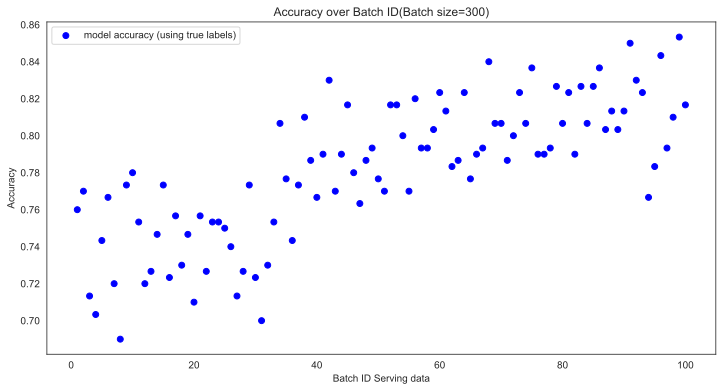

In [323]:
import matplotlib.pyplot as plt

# 设置final_accuracy和accuracy_sample的值，例如这里设置为一些随机值


# 画出折线图，其中x轴为1到5，y轴分别为final_accuracy和accuracy_sample
plt.figure(figsize=(12,6))
#plt.plot(range(1, 51), final_accuracy_list,'o-', color='orange', label='Accuracy_caclulate', alpha=1)
#plt.plot(range(1, 101), accuracy_sample_list, color='green', label='model accuracy (using true labels)',  alpha=0.5)
#plt.scatter(range(1, 101), final_accuracy_list, color='red', label='Accuracy_caclulate')
plt.scatter(range(1, len(accuracy_sample_list)+1), accuracy_sample_list, color='blue', label='model accuracy (using true labels)')
#plt.scatter(range(1, 101), accuracy_sample_list_2, color='blue', label='Retrained real Accuracy points')
#plt.scatter(range(1, 101), accuracy_sample_list, c=['red' if acc < 0.9 else 'none' for acc in accuracy_sample_list], edgecolors='none', label='Points need retrain')
#plt.scatter(range(1, 101), accuracy_sample_list_2, c=['blue' if acc < 0.9 else 'none' for acc in accuracy_sample_list], edgecolors='none', label='Retrained points')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] <= 0.9:
#         x.append(n)
#         y.append(accuracy_sample_list[i])
# plt.plot(x, y, 'o-',color='green',  alpha=0.5, label='Points need retrain')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] <= 0.9:
#         x.append(n)
#         y.append(accuracy_sample_list_2[i])

# # 将点连接起来
# plt.plot(x, y, 'o-',color='red',  alpha=0.5, label='Retrained points')

# 画阈值线
#plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold')

# 添加图例，横轴和纵轴标签以及标题
plt.legend()
plt.xlabel('Batch ID Serving data')
plt.ylabel('Accuracy')
plt.title('Accuracy over Batch ID(Batch size=300)')

# 显示图像
plt.show()







Text(0.5, 1.0, 'Accuracy over Batch ID(Batch size=300)')

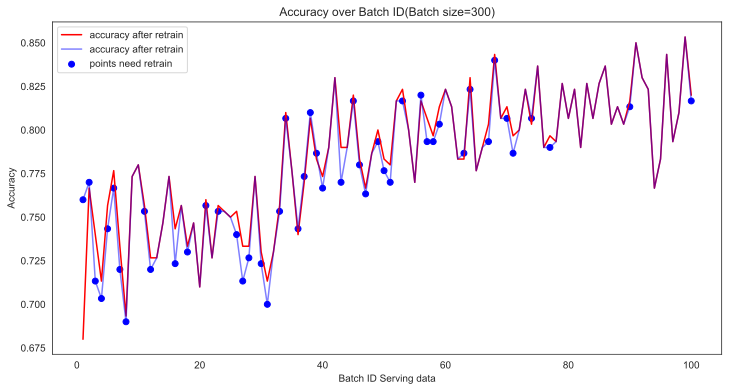

In [324]:
accuracy_sample_list_2_DDLA = accuracy_sample_list_2

plt.figure(figsize=(12,6))
plt.plot(range(1, 101), accuracy_sample_list_2, color='red', label='accuracy after retrain',  alpha=1)
plt.plot(range(1, 101), accuracy_sample_list, color='blue', label='accuracy after retrain',  alpha=0.5)
# 画阈值线
#plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold')

x = []
y = []
for i in range(100):
    n=i+1
    if accuracy_sample_list[i] != accuracy_sample_list_2[i]:
        x.append(n)
        y.append(accuracy_sample_list[i])

# 将点连接起来
plt.scatter(x, y,color='blue',  alpha=1, label='points need retrain')
#plt.scatter(range(1, 101), final_accuracy_list, color='red', label='Accuracy_caclulate')

# 添加图例，横轴和纵轴标签以及标题
plt.legend()
plt.xlabel('Batch ID Serving data')
plt.ylabel('Accuracy')
plt.title('Accuracy over Batch ID(Batch size=300)')

In [292]:
count = 0
for i in range(len(accuracy_sample_list_2)):
    if accuracy_sample_list_2[i] > accuracy_sample_list[i]:
        count += 1
print(f"{count}")

62


## K_S


In [293]:
# 定义检测函数
def drift_detection(X_train, X_test, threshold=0.05):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
    is_drift = any([result["drift"] for result in results])   

    # 返回结果列表
    return is_drift

In [294]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]

# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
Number_AL_KS=[]
trainingtime_list_KS=[]
count_retrain_KS=0
# 对每个子样本进行检测
for i in range(num_batches):
    is_drift=0
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = drift_samples_df_1[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42
                                              )
    #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    
    
    Number_AL_KS.append(0)
    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["income"])
    y_service = service_sample['income']
    y_predict = model.predict(X_service)
    acc = accuracy_score(y_service, y_predict)

    print(f"Sample {i+1}: Accuracy = {acc:.4f}")

    
    # 检测数据分布是否漂移
    is_drift = drift_detection(new_train_data.drop(columns=["income"]), X_service)



    # 记录检测结果

    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_KS+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        ###### LogisticRegression

#         model = LogisticRegression(
#                                random_state=42,
#                                solver='lbfgs')

        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=8, 
        #                        learning_rate=0.02,
        #                        n_estimators=250,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16
        #                       )
        ### XGB
        # model = XGBClassifier(max_depth=10,
        #               n_estimators=150,
        #               min_child_weight=8, 
        #               subsample=0.8, 
        #               learning_rate =0.02,    
        #               seed=42)
        
        # model = svm.SVC( random_state=42)
        #model = svm.SVC( C=0.1,random_state=42)
        x = new_train_data.drop(columns=["income"])
        y = new_train_data['income']
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############

        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_KS.append(elapsed_time)
        
        y_predict_sample = model.predict(service_sample.drop(columns=["income"]))
        y_sample = service_sample['income']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        Number_AL_KS.pop()
        Number_AL_KS.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_KS.append(0)        
        
accuracy_sample_list_KS=accuracy_sample_list

accuracy_sample_list_2_KS = accuracy_sample_list_2
print(f'KS retrain {count_retrain_KS} times' )
average_acc_KS = sum(accuracy_sample_list_2_KS) / len(accuracy_sample_list_2_KS)
print(f"Average ks methods: {average_acc_KS}")

Sample 1: Accuracy = 0.7600
The 0 retrain accuracy_sample: 0.6866666666666666
Sample 2: Accuracy = 0.7567
The 1 retrain accuracy_sample: 0.7866666666666666
Sample 3: Accuracy = 0.7533
The 2 retrain accuracy_sample: 0.78
Sample 4: Accuracy = 0.7233
The 3 retrain accuracy_sample: 0.7266666666666667
Sample 5: Accuracy = 0.7800
The 4 retrain accuracy_sample: 0.7966666666666666
Sample 6: Accuracy = 0.7967
The 5 retrain accuracy_sample: 0.7966666666666666
Sample 7: Accuracy = 0.7400
The 6 retrain accuracy_sample: 0.7533333333333333
Sample 8: Accuracy = 0.7233
The 7 retrain accuracy_sample: 0.73
Sample 9: Accuracy = 0.7767
The 8 retrain accuracy_sample: 0.79
Sample 10: Accuracy = 0.7933
The 9 retrain accuracy_sample: 0.7966666666666666
Sample 11: Accuracy = 0.7800
The 10 retrain accuracy_sample: 0.78
Sample 12: Accuracy = 0.7400
The 11 retrain accuracy_sample: 0.75
Sample 13: Accuracy = 0.7333
The 12 retrain accuracy_sample: 0.7433333333333333
Sample 14: Accuracy = 0.7533
The 13 retrain accur

## MMD


In [295]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [296]:
# # 定义检测函数
# from sklearn.metrics.pairwise import rbf_kernel
# from scipy.spatial.distance import cdist
# def mmd_fast(X, Y, sigma=None):
#     """
#     高斯核的MMD值计算函数，使用Nystrom方法加速计算
#     X: ndarray, shape (n_samples_X, n_features)
#     Y: ndarray, shape (n_samples_Y, n_features)
#     sigma: float, 高斯核的带宽参数
#     """
#     X=X.values
#     Y=Y.values
#     n_samples_X, n_samples_Y = X.shape[0], Y.shape[0]

#     # 计算高斯核矩阵
#     K_XX = rbf_kernel(X, X, gamma=1/(2*sigma**2)) if n_samples_X <= 5000 else rbf_kernel(X[:5000], X[:5000], gamma=1/(2*sigma**2))
#     K_YY = rbf_kernel(Y, Y, gamma=1/(2*sigma**2)) if n_samples_Y <= 5000 else rbf_kernel(Y[:5000], Y[:5000], gamma=1/(2*sigma**2))
#     K_XY = rbf_kernel(X, Y, gamma=1/(2*sigma**2)) if n_samples_X <= 5000 and n_samples_Y <= 5000 else rbf_kernel(X[:5000], Y[:5000], gamma=1/(2*sigma**2))

#     # 计算MMD值
#     mmd = (np.sum(K_XX) / (n_samples_X * (n_samples_X - 1)) + np.sum(K_YY) / (n_samples_Y * (n_samples_Y - 1)) - 2 * np.sum(K_XY) / (n_samples_X * n_samples_Y))
    
#     # 根据MMD值判断是否存在数据漂移
#     is_drift_mmd=False
#     if mmd > 0.001:
#         is_drift_mmd=True
#     return is_drift_mmd

In [297]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics

def mmd_fast(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
        # 根据MMD值判断是否存在数据漂移
    print(f'mmd : {mmd}')
    is_drift_mmd=False
    if mmd > 0.00345:
        is_drift_mmd=True
    return is_drift_mmd

In [298]:
# def mmd_value(X, Y, gamma=1.0):
#     """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

#     Arguments:
#         X {[n_sample1, dim]} -- [X matrix]
#         Y {[n_sample2, dim]} -- [Y matrix]

#     Keyword Arguments:
#         gamma {float} -- [kernel parameter] (default: {1.0})

#     Returns:
#         [scalar] -- [MMD value]
#     """
#     XX = metrics.pairwise.rbf_kernel(X, X, gamma)
#     YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
#     XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
#     mmd = XX.mean() + YY.mean() - 2 * XY.mean()
#         # 根据MMD值判断是否存在数据漂移

#     return mmd

In [299]:
# print(len(train_set))

In [300]:
# drift_samples_df_2= test_set
# drift_samples_df_3= test_set
# mmd_list=[]
# n=1569
# m=300
# for i in range(100):
    
#     # start_index = i * batch_size
#     # end_index = start_index + batch_size
#     # service_sample = drift_samples_df_1[start_index:end_index]
#     service_sample_2 = df_all_std.sample(n, replace=True)
#     # 在原始 DataFrame 中删除已采样的子集

#     n=n+300
#     service_sample_3 = df_all_std.sample(m, replace=True)
#     # 在原始 DataFrame 中删除已采样的子集
    
#     mmd = mmd_value(service_sample_2.drop(columns=["income"]), service_sample_3.drop(columns=["income"]))
#     mmd_list.append(mmd)

# print(mmd_list)


In [301]:
# print(np.mean(mmd_list))
# print(min(mmd_list))

In [302]:

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]

# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
Number_AL_MMD=[]
trainingtime_list_MMD=[]
count_retrain_MMD=0

# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = drift_samples_df_1[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True,random_state=42)
    # 在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    Number_AL_MMD.append(0)

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["income"])
    y_service = service_sample['income']
    y_predict = model.predict(X_service)
    acc = accuracy_score(y_service, y_predict)

    print(f"Sample {i+1}: Accuracy = {acc:.4f}")

    # 检测数据分布是否漂移

    is_drift = mmd_fast(new_train_data.drop(columns=["income"]), service_sample.drop(columns=["income"]))

    # 判断是否漂移
    #is_drift = any([result["drift"] for result in results])

    # 记录检测结果

    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_MMD+=1

        new_train_data = pd.concat([new_train_data, service_sample])
        ###### LogisticRegression

        # model = LogisticRegression(
        #                        random_state=42,
        #                        solver='lbfgs')

        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=8, 
        #                        learning_rate=0.02,
        #                        n_estimators=250,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16
        #                       )
        
        
        # model = svm.SVC( random_state=42)
        # model = XGBClassifier(max_depth=12,
        #       n_estimators=150,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
        x = new_train_data.drop(columns=["income"])
        y = new_train_data['income']
        ##########
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_MMD.append(elapsed_time)
        ###########
        y_predict_sample = model.predict(service_sample.drop(columns=["income"]))
        y_sample = service_sample['income']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        
        Number_AL_MMD.pop()
        Number_AL_MMD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_MMD.append(0)        
        


accuracy_sample_list_MMD=accuracy_sample_list
accuracy_sample_list_2_MMD = accuracy_sample_list_2
print(f'MMD retrain {count_retrain_MMD} times' )

Sample 1: Accuracy = 0.7600
mmd : 0.009920576418410532
The 0 retrain accuracy_sample: 0.6866666666666666
Sample 2: Accuracy = 0.7567
mmd : 0.006915380708755583
The 1 retrain accuracy_sample: 0.7866666666666666
Sample 3: Accuracy = 0.7533
mmd : 0.005847510863486386
The 2 retrain accuracy_sample: 0.78
Sample 4: Accuracy = 0.7233
mmd : 0.005124047685786606
The 3 retrain accuracy_sample: 0.7266666666666667
Sample 5: Accuracy = 0.7800
mmd : 0.00454172577561667
The 4 retrain accuracy_sample: 0.7966666666666666
Sample 6: Accuracy = 0.7967
mmd : 0.0043320089682764564
The 5 retrain accuracy_sample: 0.7966666666666666
Sample 7: Accuracy = 0.7400
mmd : 0.004248433912619746
The 6 retrain accuracy_sample: 0.7533333333333333
Sample 8: Accuracy = 0.7233
mmd : 0.003939145453088417
The 7 retrain accuracy_sample: 0.73
Sample 9: Accuracy = 0.7767
mmd : 0.00422452700405709
The 8 retrain accuracy_sample: 0.79
Sample 10: Accuracy = 0.7933
mmd : 0.0039454695357013375
The 9 retrain accuracy_sample: 0.79666666

## H-D

In [303]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [304]:

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]

# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
accuracy_before_retrain = []
Number_AL_HD=[]
trainingtime_list_HD=[]
count_retrain_HD=0
# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size,  replace=True,random_state=42)
    #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)

    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    Number_AL_HD.append(0)    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["income"])
    y_service = service_sample['income']
    y_predict = model.predict(X_service)
    acc = accuracy_score(y_service, y_predict)

    
    # 检测数据分布是否漂移
    is_drift = evaluate(new_train_data.drop(columns=["income"]), X_service)
    is_drift_list.append(is_drift)
    
    # 判断是否漂移
    #is_drift = any([result["drift"] for result in results])
    # if bad_drift == is_drift == 1:
    #     detect_right= True
    # else:
    #     detect_right= False
    # 记录检测结果

    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_HD+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        ###### LogisticRegression

        # model = LogisticRegression(
        #                        random_state=42,
        #                        solver='lbfgs')

        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=8, 
        #                        learning_rate=0.02,
        #                        n_estimators=250,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16
        #                       )
        # model = svm.SVC( random_state=42)
        # model = XGBClassifier(max_depth=12,
        #                       n_estimators=150,
        #                       min_child_weight=8, 
        #                       subsample=0.8, 
        #                       learning_rate =0.02,    
        #                       seed=42)
        x = new_train_data.drop(columns=["income"])
        y = new_train_data['income']
        ##########
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_HD.append(elapsed_time)
        y_predict_sample = model.predict(service_sample.drop(columns=["income"]))
        y_sample = service_sample['income']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        
        Number_AL_HD.pop()
        Number_AL_HD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_HD.append(0)
        
        

# 将结果保存到CSV文件中

accuracy_sample_list_HD=accuracy_sample_list
accuracy_sample_list_2_HD = accuracy_sample_list_2
print(f'HD retrain {count_retrain_HD} times' )

The 0 retrain accuracy_sample: 0.6866666666666666
The 1 retrain accuracy_sample: 0.7866666666666666
The 2 retrain accuracy_sample: 0.78
The 3 retrain accuracy_sample: 0.7266666666666667
The 4 retrain accuracy_sample: 0.7966666666666666
The 5 retrain accuracy_sample: 0.7966666666666666
The 6 retrain accuracy_sample: 0.7533333333333333
The 7 retrain accuracy_sample: 0.73
The 8 retrain accuracy_sample: 0.79
The 9 retrain accuracy_sample: 0.7966666666666666
The 10 retrain accuracy_sample: 0.78
The 11 retrain accuracy_sample: 0.75
The 12 retrain accuracy_sample: 0.7433333333333333
The 13 retrain accuracy_sample: 0.7633333333333333
The 14 retrain accuracy_sample: 0.7833333333333333
The 15 retrain accuracy_sample: 0.7666666666666667
The 16 retrain accuracy_sample: 0.76
The 17 retrain accuracy_sample: 0.74
The 18 retrain accuracy_sample: 0.76
The 19 retrain accuracy_sample: 0.74
The 20 retrain accuracy_sample: 0.78
The 21 retrain accuracy_sample: 0.7533333333333333
The 22 retrain accuracy_samp

## baseline: No retrain

In [305]:

drift_samples_df_1= test_set
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")
accuracy_no_retrain = []
# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
        #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["income"])
    y_service = service_sample['income']
    y_predict = model.predict(X_service)
    acc = accuracy_score(y_service, y_predict)
    accuracy_no_retrain.append(acc)
    


## Baseline: Random sample the same number with out method to retrain

In [306]:
# import joblib
# model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")



# drift_samples_df_1= test_set

# drift_samples_df= train_set
# new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')




# accuracy_sample_list_2 = []
# accuracy_sample_list = []


# # 对每个子样本进行检测
# for i in range(num_batches):

#     # start_index = i * batch_size
#     # end_index = start_index + batch_size
#     # service_sample = drift_samples_df_1[start_index:end_index]
#     # 进行有放回的随机采样
#     service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
#     drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
#     # 获取当前子样本
#     #service_sample = test_df.iloc[i*1000:(i+1)*1000]
#     #if i % 2 == 1:
#     # 余数为 1，执行操作 1
#         #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
#     #else:
#     # 余数为 0，执行操作 2
#     #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    
    

    

#     # 获取子样本的特征和标签
#     # 获取子样本的特征和标签
#     X_service = service_sample.drop(columns=["income"])
#     y_service = service_sample['income']
#     y_predict = model.predict(X_service)
#     acc = accuracy_score(y_service, y_predict)

#     # drift_results.append({
#     #     "sample_id": i+1,
#     #     # "drift": any([result["drift"] for result in results]),
#     #     "bad_drift": bad_drift,
#     #     "detect_right": detect_right,
#     #     "results": results
#     # })
#     accuracy_sample_list_2.append(acc)
#     accuracy_sample_list.append(acc)
#     # 如果漂移，记录检测到漂移的样本编号

#     if Number_AL[i]:
#         n=Number_AL[i]
#         service_sample_choose=service_sample.sample(n, replace=False, random_state=42)

#         new_train_data = pd.concat([new_train_data, service_sample_choose])
#         ###### LogisticRegression

#         # model = LogisticRegression(C=0.8,
#         #                        random_state=42,
#         #                        solver='lbfgs')
#         # model = DecisionTreeClassifier(random_state=42
#         #                        )
        
#         # model = svm.SVC( random_state=42)
#         ###### LightGBM

#         # model = LGBMClassifier(num_leaves=31,
#         #                max_depth=8, 
#         #                learning_rate=0.02,
#         #                n_estimators=250,
#         #                subsample = 0.8,
#         #                colsample_bytree =0.8,
#         #                 random_state=42
#         #               ) 
#         # model = RandomForestClassifier(n_estimators=250,
#         #                       max_depth=12,
#         #                       min_samples_leaf=16
#         #                       )
#         # model = svm.SVC( random_state=42)
        
#         # model = XGBClassifier(max_depth=12,
#         #                       n_estimators=150,
#         #                       min_child_weight=8, 
#         #                       subsample=0.8, 
#         #                       learning_rate =0.02,    
#         #                       seed=42)        
#         x = new_train_data.drop(columns=["income"])
#         y = new_train_data['income']
#         ##########
#         y = y.astype('int')
#         oversample = SMOTE(random_state=42)
#         X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
#         X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
#         ############
 
#         model.fit(X_balance_re, Y_balance_re)
     
        
#         y_predict_sample = model.predict(service_sample.drop(columns=["income"]))
#         y_sample = service_sample['income']
#         accuracy_sample = accuracy_score(y_sample, y_predict_sample)
#         accuracy_sample_list_2.pop()
#         accuracy_sample_list_2.append(accuracy_sample)

#         print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
#         new_train_data = new_train_data.reset_index(drop=True)

        
# accuracy_sample_list_baseline_low2=accuracy_sample_list

# accuracy_sample_list_2_baseline_low2 = accuracy_sample_list_2

## real ramdom

In [325]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")



drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

average_number_al = int(sum(Number_AL) / len(Number_AL))


accuracy_sample_list_2 = []
accuracy_sample_list = []
trainingtime_list_real_random=[]

# 对每个子样本进行检测
for i in range(num_batches):

    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = drift_samples_df_1[start_index:end_index]
    # 进行有放回的随机采样
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    
    

    

    # 获取子样本的特征和标签
    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["income"])
    y_service = service_sample['income']
    y_predict = model.predict(X_service)
    # y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    # drift_results.append({
    #     "sample_id": i+1,
    #     # "drift": any([result["drift"] for result in results]),
    #     "bad_drift": bad_drift,
    #     "detect_right": detect_right,
    #     "results": results
    # })
    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号


    service_sample_choose=service_sample.sample(average_number_al, replace=False, random_state=42)

    new_train_data = pd.concat([new_train_data, service_sample_choose])
    ###### LogisticRegression

    # model = LogisticRegression(C=0.1,
    #                        random_state=42,
    #                        solver='lbfgs')
    # model = DecisionTreeClassifier(random_state=42
    #                        )

    # model = svm.SVC( random_state=42)
    ###### LightGBM

    # model = LGBMClassifier(num_leaves=31,
    #                max_depth=5, 
    #                learning_rate=0.02,
    #                n_estimators=100,
    #                subsample = 0.8,
    #                colsample_bytree =0.8
    #               )
    # model = RandomForestClassifier(n_estimators=250,
    #                       max_depth=12,
    #                       min_samples_leaf=16,
    #                                random_state=42
    #                       )

    # model = XGBClassifier(max_depth=6,
    #       n_estimators=100,
    #       min_child_weight=8, 
    #       subsample=0.8, 
    #       learning_rate =0.02,    
    #       seed=42)       
    x = new_train_data.drop(columns=["income"])
    y = new_train_data['income']
    ##########
    y = y.astype('int')
    oversample = SMOTE(random_state=42)
    X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
    X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
    ############

    ############
    start_time = time.time()
    model.fit(X_balance_re, Y_balance_re)
    # 记录结束时间
    end_time = time.time()

    # 计算时间差
    elapsed_time = end_time - start_time
    trainingtime_list_real_random.append(elapsed_time)


    y_predict_sample = model.predict(service_sample.drop(columns=["income"]))
    #y_predict_sample = (y_predict_sample > 0.5).astype(int)
    y_sample = service_sample['income']
    accuracy_sample = accuracy_score(y_sample, y_predict_sample)
    accuracy_sample_list_2.pop()
    accuracy_sample_list_2.append(accuracy_sample)

    print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
    new_train_data = new_train_data.reset_index(drop=True)

        
accuracy_sample_list_baseline_real_low2=accuracy_sample_list

accuracy_sample_list_2_real_baseline_low2 = accuracy_sample_list_2

The 0 retrain accuracy_sample: 0.7366666666666667
The 1 retrain accuracy_sample: 0.7766666666666666
The 2 retrain accuracy_sample: 0.7166666666666667
The 3 retrain accuracy_sample: 0.7033333333333334
The 4 retrain accuracy_sample: 0.7533333333333333
The 5 retrain accuracy_sample: 0.7366666666666667
The 6 retrain accuracy_sample: 0.7166666666666667
The 7 retrain accuracy_sample: 0.6766666666666666
The 8 retrain accuracy_sample: 0.7366666666666667
The 9 retrain accuracy_sample: 0.78
The 10 retrain accuracy_sample: 0.7566666666666667
The 11 retrain accuracy_sample: 0.7166666666666667
The 12 retrain accuracy_sample: 0.72
The 13 retrain accuracy_sample: 0.7333333333333333
The 14 retrain accuracy_sample: 0.73
The 15 retrain accuracy_sample: 0.6866666666666666
The 16 retrain accuracy_sample: 0.71
The 17 retrain accuracy_sample: 0.6866666666666666
The 18 retrain accuracy_sample: 0.7233333333333334
The 19 retrain accuracy_sample: 0.6966666666666667
The 20 retrain accuracy_sample: 0.753333333333

In [326]:
# accuracy_sample_list_2_HD=accuracy_sample_list_2


list3=accuracy_sample_list_2_KS
list1=accuracy_sample_list_2_DDLA
list2=accuracy_sample_list_2_HD
list4=accuracy_sample_list_2_MMD
#list5=accuracy_sample_list_2_baseline_low2
list8=accuracy_sample_list_2_real_baseline_low2
list7=accuracy_no_retrain
# list5=accuracy_sample_list_HD
# list6=accuracy_sample_list_DDLA

In [327]:
#accuracy_sample_list_2 = pd.DataFrame(accuracy_sample_list_2, columns=['accuracy'])
#accuracy_sample_list_2.to_csv('/Users/sdong/phd_doc/att/weather_data/accuracy_sample_list_2.csv')

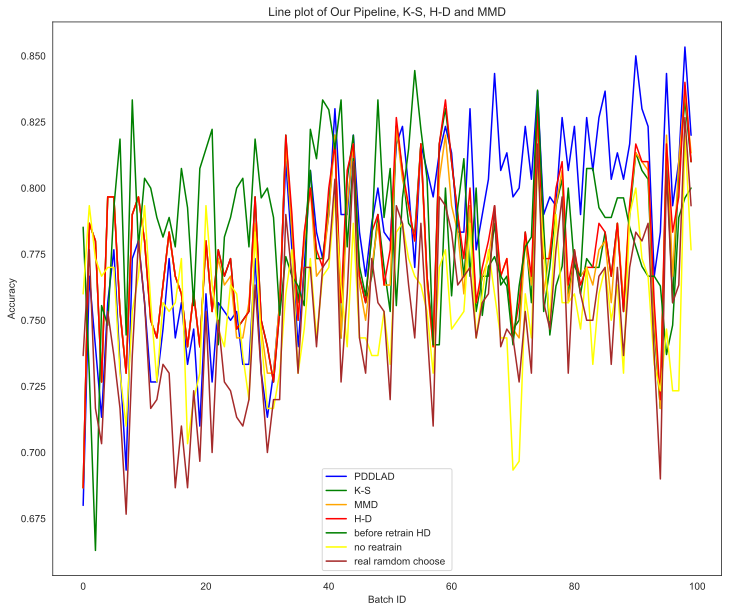

Average Oue methods: 0.7838666666666664
Average KS: 0.7748999999999998
Average MMD: 0.7741000000000002
Average HD: 0.7772333333333333
Average no retrain: 0.7553666666666663
real ramdom choose retrain: 0.7503666666666665
54


In [328]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
x_axis = list(range(len(list1)))

plt.plot(x_axis, list1, color='blue', label='PDDLAD')

plt.plot(x_axis, list3, color='green', label='K-S')
plt.plot(x_axis, list4, color='orange', label='MMD')
plt.plot(x_axis, list2, color='red', label='H-D')
plt.plot(x_axis, list5, color='green', label='before retrain HD')
# plt.plot(x_axis, list6, color='orange', label='before reatrain DDLA')
plt.plot(x_axis, list7, color='yellow', label='no reatrain')
#plt.plot(x_axis, list5, color='black', label='ramdom choose same number to retrain')
plt.plot(x_axis, list8, color='brown', label='real ramdom choose ')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

average_list1 = sum(list1) / len(list1)
print(f"Average Oue methods: {average_list1}")
average_list3 = sum(list3) / len(list3)
print(f"Average KS: {average_list3}")
average_list4 = sum(list4) / len(list4)
print(f"Average MMD: {average_list4}")
average_list2 = sum(list2) / len(list2)
print(f"Average HD: {average_list2}")
average_list7 = sum(list7) / len(list7)
print(f"Average no retrain: {average_list7}")
# average_list5 = sum(list5) / len(list5)
# print(f"Average ramdom choose retrain: {average_list5}")
average_list8 = sum(list8) / len(list8)
print(f"real ramdom choose retrain: {average_list8}")
count = sum(x > y for x, y in zip(list1, list3))
print(count)

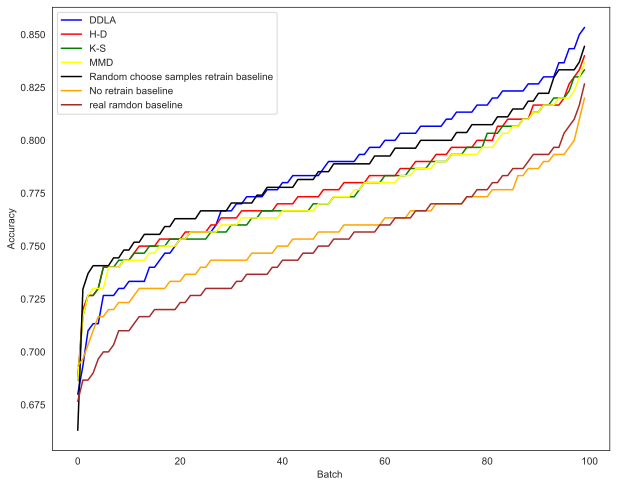

In [329]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(list1)))

plt.plot(x_axis, np.sort(list1), color='blue', label='DDLA')
plt.plot(x_axis, np.sort(list2), color='red', label='H-D')
plt.plot(x_axis, np.sort(list3), color='green', label='K-S')
plt.plot(x_axis, np.sort(list4), color='yellow', label='MMD')
plt.plot(x_axis, np.sort(list5), color='black', label='Random choose samples retrain baseline')
plt.plot(x_axis, np.sort(list7), color='orange', label='No retrain baseline')
plt.plot(x_axis, np.sort(list8), color='brown', label='real ramdon baseline')


plt.legend()

plt.xlabel('Batch ')
plt.ylabel('Accuracy')
#plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

In [330]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,8))
# x_axis = list(range(len(list1)))
# print(len(list1))
# plt.plot(x_axis, np.sort(list1), color='blue', label='PDDLAD')
# #plt.plot(x_axis, np.asarray(list2)[np.argsort(list1)], color='red', label='H-D')
# plt.plot(x_axis, np.asarray(list3)[np.argsort(list1)], color='green', label='K-S')
# #plt.plot(x_axis, np.asarray(list4)[np.argsort(list1)], color='orange', label='MMD')
# plt.legend()

# plt.xlabel('Batch ID')
# plt.ylabel('Accuracy')
# plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

# plt.show()

100


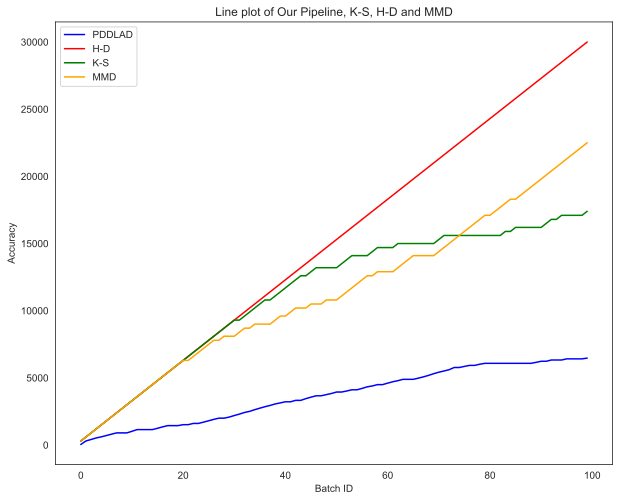

PDDLA the number that expert labeled: 6471
KS the number that expert labeled: 17400
HD the number that expert labeled: 30000
MMD the number that expert labeled: 22500


In [331]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(Number_AL)))
# 对x进行累加
print(len(Number_AL))
Number_AL_cumsum = np.cumsum(Number_AL)
Number_AL_KS_cumsum = np.cumsum(Number_AL_KS)
Number_AL_MMD_cumsum = np.cumsum(Number_AL_MMD)
Number_AL_HD_cumsum = np.cumsum(Number_AL_HD)
# print(Number_AL_cumsum.shape)
# print(Number_AL_KS_cumsum)
plt.plot(x_axis, Number_AL_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, Number_AL_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, Number_AL_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, Number_AL_MMD_cumsum, color='orange', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()
print(f"PDDLA the number that expert labeled: {Number_AL_cumsum[-1]}")
print(f"KS the number that expert labeled: {Number_AL_KS_cumsum[-1]}")
print(f"HD the number that expert labeled: {Number_AL_HD_cumsum[-1]}")
print(f"MMD the number that expert labeled: {Number_AL_MMD_cumsum[-1]}")

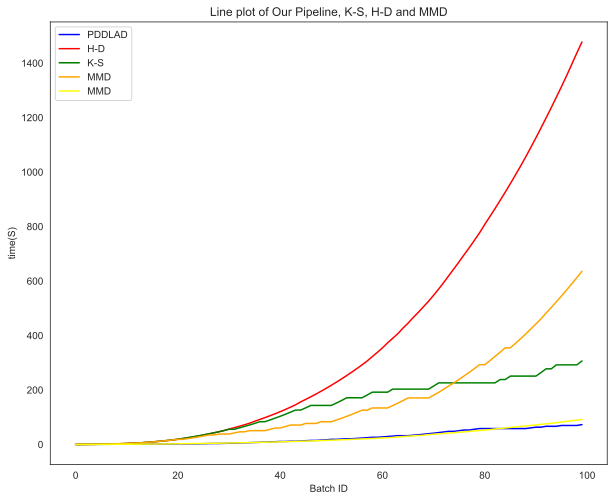

PDDLA retraining time: 72.89325261116028
KS retraining time: 306.4225995540619
MMD retraining time: 635.6766014099121
HD retraining time: 1477.4471542835236
real ramdom retraining time: 91.74873304367065


In [332]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(trainingtime_list)))
# 对x进行累加
#print(len(Number_AL))
trainingtime_list_cumsum = np.cumsum(trainingtime_list)
trainingtime_list_KS_cumsum = np.cumsum(trainingtime_list_KS)
trainingtime_list_MMD_cumsum = np.cumsum(trainingtime_list_MMD)
trainingtime_list_HD_cumsum = np.cumsum(trainingtime_list_HD)
trainingtime_list_real_random_cumsum = np.cumsum(trainingtime_list_real_random)

plt.plot(x_axis, trainingtime_list_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, trainingtime_list_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, trainingtime_list_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, trainingtime_list_MMD_cumsum, color='orange', label='MMD')
plt.plot(x_axis, trainingtime_list_real_random_cumsum, color='yellow', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('time(S)')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

print(f"PDDLA retraining time: {trainingtime_list_cumsum[-1]}")
print(f"KS retraining time: {trainingtime_list_KS_cumsum[-1]}")
print(f"MMD retraining time: {trainingtime_list_MMD_cumsum[-1]}")
print(f"HD retraining time: {trainingtime_list_HD_cumsum[-1]}")
print(f"real ramdom retraining time: {trainingtime_list_real_random_cumsum[-1]}")